In [1]:
# importing modules and libraries

import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.layers import Input, InputLayer, Conv2D, MaxPooling2D, Flatten, ELU, Dense, BatchNormalization, Activation
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.optimizers import Nadam

2024-06-04 06:13:39.499033: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 06:13:39.499153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 06:13:39.592003: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from pathlib import Path
import imghdr

data_dir = "/kaggle/input/indonesian-spices-dataset/Indonesian Spices Dataset"
image_extensions = [".png", ".jpg"]  # specific filetypes to be focused on for checking

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"] # Keras only allows following extensions for data loading currently

image_type_count = {}  # Dictionary to store counts of true image types

for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            img_type = "Unknown"  # If there's no file type, mark it as "Unknown"
        elif img_type not in img_type_accepted_by_tf:
            img_type = "NotAcceptedByTF"  # If file type is not accepted by TensorFlow, mark it as "NotAcceptedByTF"
        
        # Update count in the dictionary
        image_type_count[img_type] = image_type_count.get(img_type, 0) + 1

# Print the dictionary containing counts of true image types
print("Count of true image types:")
for img_type, count in image_type_count.items():
    print(f"{img_type}: {count}")

Count of true image types:
jpeg: 6045
Unknown: 249
NotAcceptedByTF: 180
png: 33


In [3]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image

def load_images_from_directory(directory, image_extensions, image_size=(224, 224), batch_size=32):
    valid_images = []
    valid_labels = []

    label_to_index = {}  # Dictionary to map labels to integer indices
    index = 0

    for root, _, files in os.walk(directory):
        for file in files:
            if any(file.lower().endswith(extension) for extension in image_extensions):
                file_path = os.path.join(root, file)
                try:
                    # Open the image using PIL
                    with Image.open(file_path) as img:
                        # Convert the image to RGB format
                        img_rgb = img.convert("RGB")
                        # Resize the image
                        img_resized = img_rgb.resize(image_size)
                        # Convert image to numpy array and normalize
                        img_array = np.array(img_resized) / 255.0
                        valid_images.append(img_array)
                        label = os.path.basename(root)  # Assuming directory name is the label
                        if label not in label_to_index:
                            label_to_index[label] = index
                            index += 1
                        valid_labels.append(label_to_index[label])
                except Exception as e:
                    print(f"Error processing image {file_path}: {e}")

    valid_images = np.array(valid_images)
    valid_labels = tf.keras.utils.to_categorical(valid_labels)

    return valid_images, valid_labels

data_dir = "/kaggle/input/indonesian-spices-dataset/Indonesian Spices Dataset"
image_extensions = [".jpeg", ".jpg", ".png", ".webp"]

train_images, train_labels = load_images_from_directory(data_dir, image_extensions)

print("Shape of train images array:", train_images.shape)
print("Shape of train labels array:", train_labels.shape)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Shape of train images array: (6510, 224, 224, 3)
Shape of train labels array: (6510, 31)


In [4]:
# Split the data
from sklearn.model_selection import train_test_split
x_train, x_temp, y_train, y_temp = train_test_split(train_images, train_labels, test_size=0.4,random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5,random_state=42)

print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)

x_train: (3906, 224, 224, 3)
y_train: (3906, 31)
x_test: (1302, 224, 224, 3)
y_test: (1302, 31)
x_val: (1302, 224, 224, 3)
y_val: (1302, 31)


In [5]:
import gc # calling garbage collector to reduce memory utilization

del train_images
del train_labels

gc.collect()

0

In [6]:
from keras import mixed_precision # changing precision policies
mixed_precision.set_global_policy('mixed_float16')

In [7]:
tf.config.optimizer.set_jit(True) # setting optimizer to reduce model computation by optimizing graph-computations

### VGG16

In [8]:
from keras.applications import VGG16
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau

# Loading model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer('block4_pool').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Adding dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(31, activation='softmax')(x)

# binding model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

model.summary() # printing summary of model

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31)             │        31,775 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,192,351 (31.25 MB)

 Trainable params: 557,087 (2.13 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=50,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
 3/79 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9811 - loss: 0.0528 

W0000 00:00:1717439295.897348     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9701 - loss: 0.1013

W0000 00:00:1717439304.080295     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy did not improve from 0.87020
79/79 ━━━━━━━━━━━━━━━━━━━━ 40s 134ms/step - accuracy: 0.9701 - loss: 0.1012 - val_accuracy: 0.8349 - val_loss: 0.6565 - learning_rate: 0.0010
Epoch 2/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9757 - loss: 0.0691
Epoch 2: val_accuracy did not improve from 0.87020
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.9758 - loss: 0.0691 - val_accuracy: 0.8602 - val_loss: 0.5701 - learning_rate: 0.0010
Epoch 3/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9818 - loss: 0.0585
Epoch 3: val_accuracy did not improve from 0.87020
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.9819 - loss: 0.0583 - val_accuracy: 0.8441 - val_loss: 0.7008 - learning_rate: 0.0010
Epoch 4/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9847 - loss: 0.0603
Epoch 4: val_accuracy did not improve from 0.87020
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.9846 - loss: 0.0603 - val_accuracy: 0.8571 - val_loss: 0.6008 - 

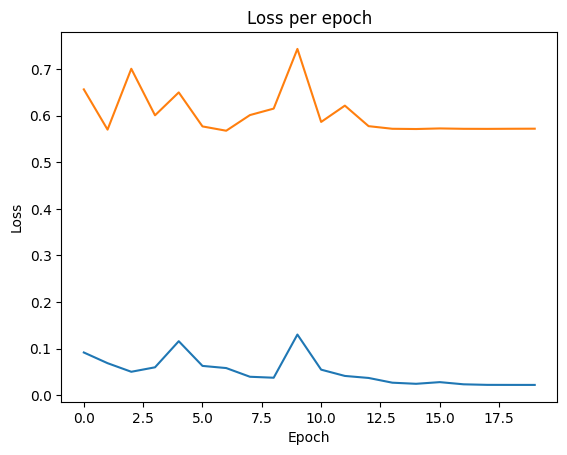

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

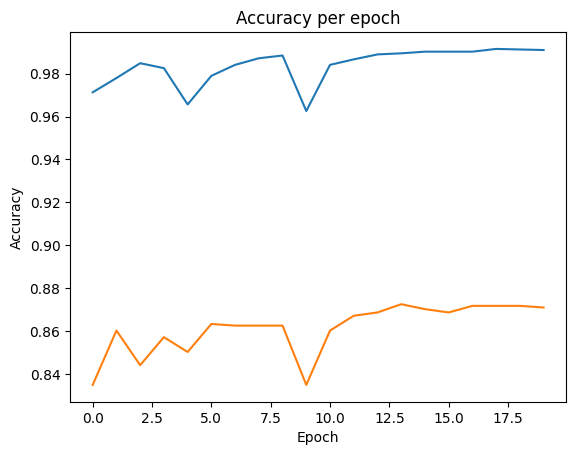

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### ResNet50

In [8]:
from keras.applications import ResNet50
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Loading model
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=resnet50_model.input, outputs=resnet50_model.get_layer('conv5_block3_out').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Adding dense layers on top
x = feature_extractor.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(31, activation='softmax')(x)

# binding model
model = Model(inputs=feature_extractor.input, outputs=output)

# Setting callbacks
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

model.summary() # model summary

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 126,380,959 (482.11 MB)

 Trainable params: 102,793,247 (392.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=50,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
 1/79 ━━━━━━━━━━━━━━━━━━━━ 27:41 21s/step - accuracy: 0.0400 - loss: 4.2439

I0000 00:00:1717440935.876880     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.0361 - loss: 12.8093
Epoch 1: val_accuracy improved from -inf to 0.02919, saving model to model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 57s 459ms/step - accuracy: 0.0360 - loss: 12.8346 - val_accuracy: 0.0292 - val_loss: 15.6477 - learning_rate: 0.0010
Epoch 2/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.0282 - loss: 15.6637
Epoch 2: val_accuracy did not improve from 0.02919
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.0282 - loss: 15.6631 - val_accuracy: 0.0292 - val_loss: 15.6477 - learning_rate: 0.0010
Epoch 3/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.0291 - loss: 15.6491
Epoch 3: val_accuracy did not improve from 0.02919
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.0291 - loss: 15.6489 - val_accuracy: 0.0292 - val_loss: 15.6477 - learning_rate: 0.0010
Epoch 4/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.0331 - loss: 15.5843
Epoch 4: val_accuracy did not improve from 0.02919
79/7

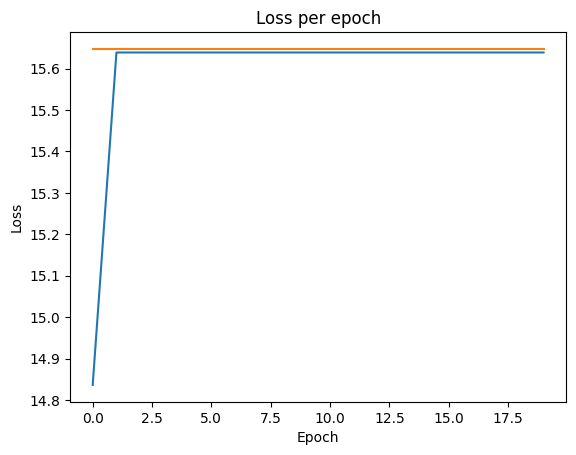

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

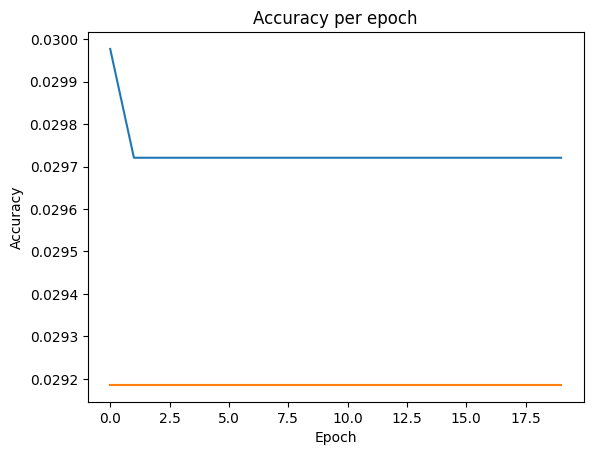

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### DenseNet121

In [8]:
from keras.applications import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Loading model
densenet121_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=densenet121_model.input, outputs=densenet121_model.get_layer('conv5_block6_concat').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False
    
# Adding dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)
output = Dense(31, activation='softmax')(x)

# binding model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

model.summary() # model summary

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 6,293,983 (24.01 MB)

 Trainable params: 753,695 (2.88 MB)

 Non-trainable params: 5,540,288 (21.13 MB)

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=50,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
 2/79 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.0600 - loss: 3.4290  

I0000 00:00:1717441282.904047     531 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717441282.973644     531 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.2985 - loss: 2.8827

W0000 00:00:1717441312.804639     530 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.64747, saving model to model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 83s 593ms/step - accuracy: 0.3005 - loss: 2.8761 - val_accuracy: 0.6475 - val_loss: 1.4468 - learning_rate: 0.0010
Epoch 2/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6970 - loss: 1.2465
Epoch 2: val_accuracy improved from 0.64747 to 0.76651, saving model to model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.6976 - loss: 1.2438 - val_accuracy: 0.7665 - val_loss: 0.8818 - learning_rate: 0.0010
Epoch 3/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7701 - loss: 0.8318
Epoch 3: val_accuracy improved from 0.76651 to 0.84025, saving model to model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.7707 - loss: 0.8306 - val_accuracy: 0.8402 - val_loss: 0.6544 - learning_rate: 0.0010
Epoch 4/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8287 - loss: 0.6345
Epoch 4: val_accuracy improved from 0.84025 to 0.86406, saving model to m

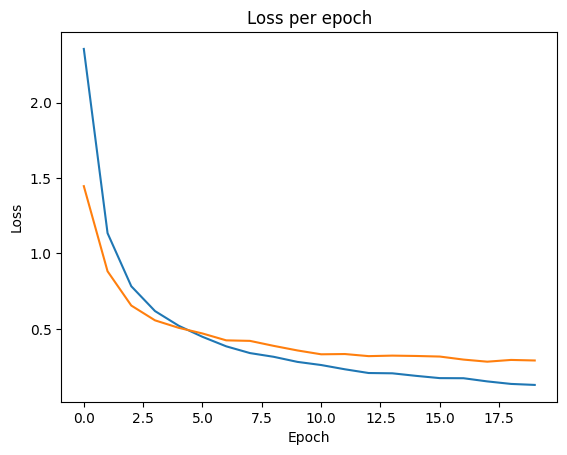

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

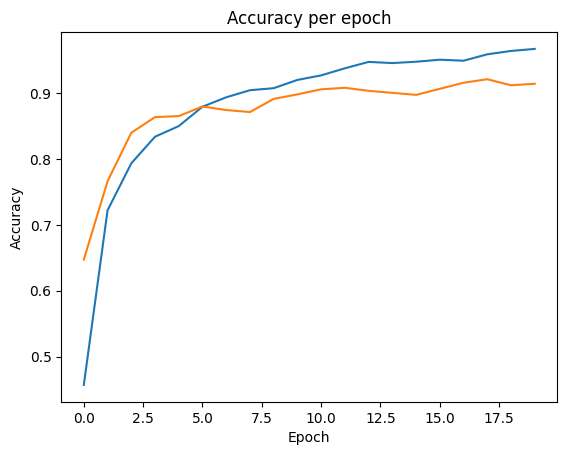

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### Xception

In [8]:
from keras.applications import Xception
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Loading model
xception_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=xception_model.input, outputs=xception_model.get_layer('block14_sepconv2_act').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Adding dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(31, activation='softmax')(x)

# binding model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

model.summary() # model summary

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 22,991,431 (87.71 MB)

 Trainable params: 2,129,951 (8.13 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=50,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
 2/79 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.0550 - loss: 3.6075  

I0000 00:00:1717441712.164653     957 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.4522 - loss: 2.0492
Epoch 1: val_accuracy improved from -inf to 0.79724, saving model to model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 44s 282ms/step - accuracy: 0.4544 - loss: 2.0403 - val_accuracy: 0.7972 - val_loss: 0.6802 - learning_rate: 0.0010
Epoch 2/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8554 - loss: 0.4592
Epoch 2: val_accuracy improved from 0.79724 to 0.82949, saving model to model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.8555 - loss: 0.4588 - val_accuracy: 0.8295 - val_loss: 0.5482 - learning_rate: 0.0010
Epoch 3/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9234 - loss: 0.2562
Epoch 3: val_accuracy did not improve from 0.82949
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.9233 - loss: 0.2562 - val_accuracy: 0.8287 - val_loss: 0.5283 - learning_rate: 0.0010
Epoch 4/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9204 - loss: 0.3811
Epoch 4: val_accuracy improved f

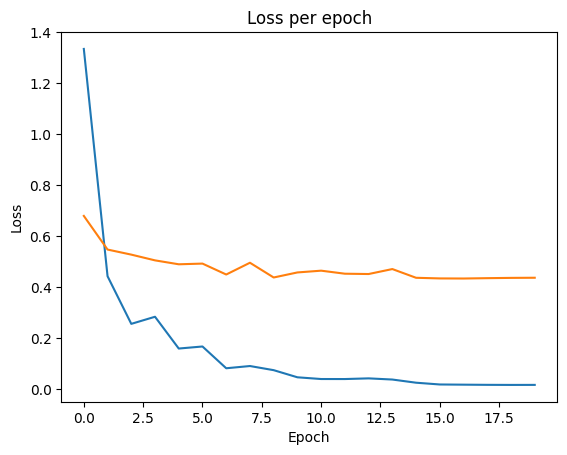

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

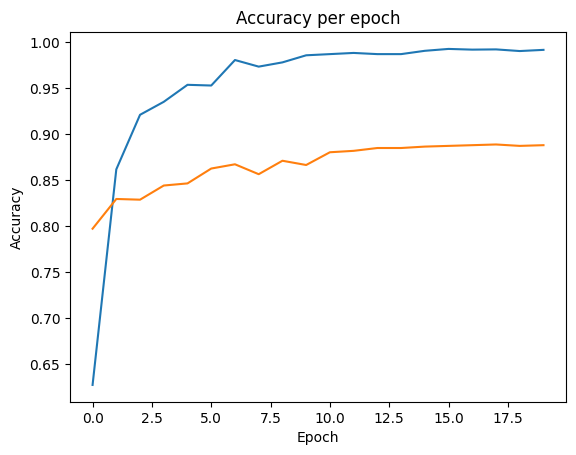

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### Inception

In [8]:
from keras.applications import InceptionV3
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Loading model
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=inception_model.input, outputs=inception_model.get_layer('mixed10').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Adding dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(31, activation='softmax')(x)

# binding model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

model.summary() # model summary

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 23,932,735 (91.30 MB)

 Trainable params: 2,129,951 (8.13 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=50,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
 3/79 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.0311 - loss: 3.8650 

I0000 00:00:1717442046.071121    1376 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.2840 - loss: 3.0951
Epoch 1: val_accuracy improved from -inf to 0.73118, saving model to model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 63s 461ms/step - accuracy: 0.2866 - loss: 3.0818 - val_accuracy: 0.7312 - val_loss: 0.8622 - learning_rate: 0.0010
Epoch 2/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8011 - loss: 0.7015
Epoch 2: val_accuracy improved from 0.73118 to 0.76114, saving model to model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.8014 - loss: 0.6998 - val_accuracy: 0.7611 - val_loss: 0.7882 - learning_rate: 0.0010
Epoch 3/20
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8921 - loss: 0.3720
Epoch 3: val_accuracy improved from 0.76114 to 0.77419, saving model to model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.8919 - loss: 0.3719 - val_accuracy: 0.7742 - val_loss: 0.8229 - learning_rate: 0.0010
Epoch 4/20
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8832 - loss: 0.3937

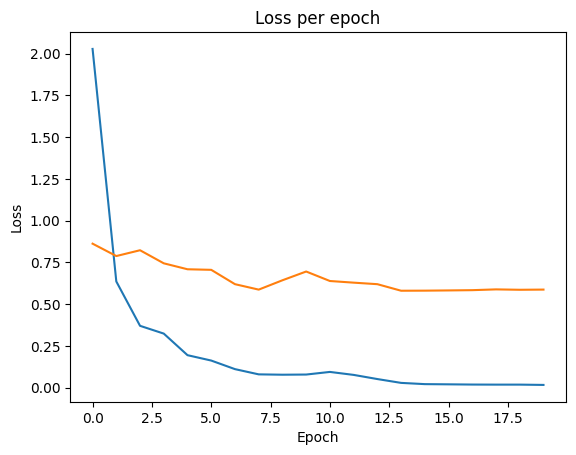

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

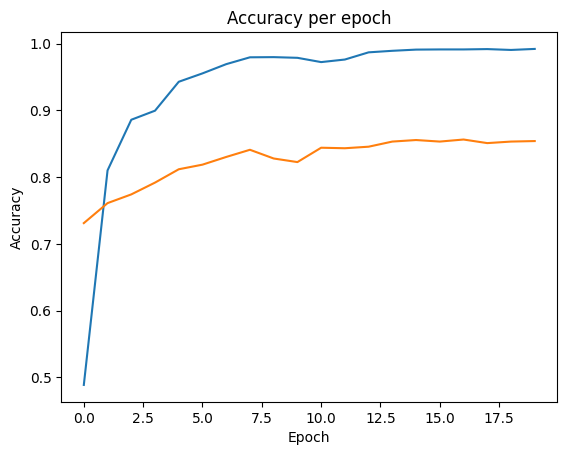

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### EfficientNet

In [8]:
from keras.applications import EfficientNetB7
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Loading model
efficientnet_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=efficientnet_model.input, outputs=efficientnet_model.get_layer('block4d_project_bn').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Adding dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(31, activation='softmax')(x)

# binding model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

model.summary() # model summary

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,728 │ stem_conv_pad[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        576 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        256 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 64)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 64)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 16)  │      1,040 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 64)  │      1,088 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 64)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      2,048 │ block1a_se_excit

 Total params: 2,551,342 (9.73 MB)

 Trainable params: 196,639 (768.12 KB)

 Non-trainable params: 2,354,703 (8.98 MB)

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=50,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
 1/79 ━━━━━━━━━━━━━━━━━━━━ 1:14:58 58s/step - accuracy: 0.0200 - loss: 3.5291

I0000 00:00:1717477211.547515     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.0333 - loss: 3.5048
Epoch 1: val_accuracy improved from -inf to 0.03072, saving model to model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 120s 797ms/step - accuracy: 0.0333 - loss: 3.5045 - val_accuracy: 0.0307 - val_loss: 3.4463 - learning_rate: 0.0010
Epoch 2/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.0264 - loss: 3.4476
Epoch 2: val_accuracy did not improve from 0.03072
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.0265 - loss: 3.4475 - val_accuracy: 0.0261 - val_loss: 3.4443 - learning_rate: 0.0010
Epoch 3/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.0321 - loss: 3.4384
Epoch 3: val_accuracy improved from 0.03072 to 0.03533, saving model to model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.0321 - loss: 3.4385 - val_accuracy: 0.0353 - val_loss: 3.4381 - learning_rate: 0.0010
Epoch 4/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.0286 - loss: 3.4344
Epoch 4: val_accuracy did n

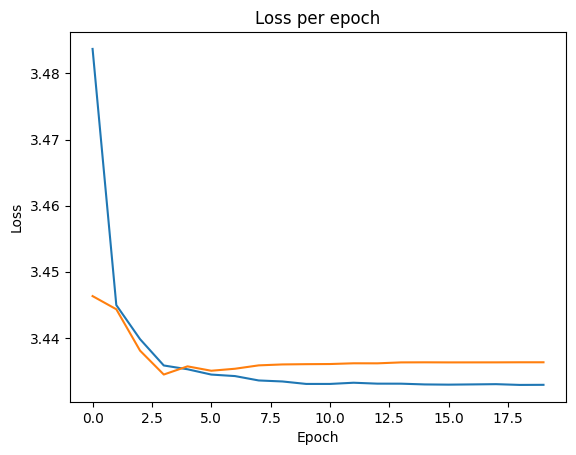

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

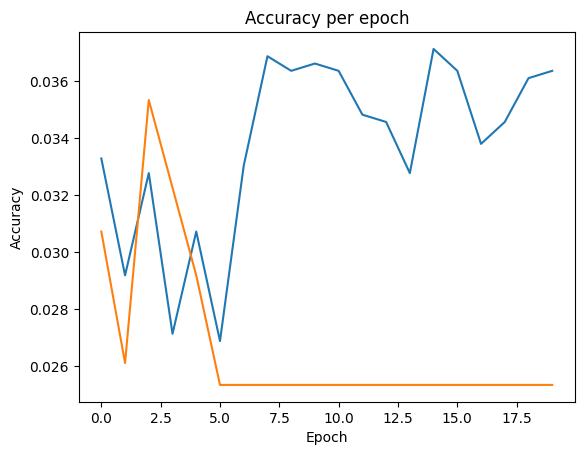

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### CNN

In [8]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, InputLayer
from keras.regularizers import l1_l2

model = Sequential()

model.add(InputLayer(shape=(224, 224, 3))) # input layer

# convolutional block
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

# convolutional block
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

# convolutional block
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

# convolutional block
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

model.add(GlobalAveragePooling2D()) # pooling down

model.add(Dense(1024, activation='relu')) # dense layer

model.add(Dense(31, activation='softmax')) # output layer

model.summary() # model summary

# model checkpoint callback
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31)             │        31,775 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211,935 (827.87 KB)

 Trainable params: 211,423 (825.87 KB)

 Non-trainable params: 512 (2.00 KB)

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=60, batch_size=50,callbacks=[model_checkpoint])

Epoch 1/60


I0000 00:00:1717481747.733361     855 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-06-04 06:16:02.167019: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng19{} for conv (f16[64,3,3,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[50,112,112,64]{3,2,1,0}, f16[50,112,112,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-04 06:16:05.171329: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 4.00453524s
Trying algorithm eng19{} for conv (f16[64,3,3,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[50,112,112,64]{3,2,1,0}, f16[50,112,112,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_c

 2/79 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.0500 - loss: 3.3975    

W0000 00:00:1717481837.600114     855 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.1827 - loss: 2.8917
Epoch 1: val_accuracy improved from -inf to 0.04071, saving model to model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 109s 207ms/step - accuracy: 0.1836 - loss: 2.8878 - val_accuracy: 0.0407 - val_loss: 4.7295
Epoch 2/60
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3241 - loss: 2.1202
Epoch 2: val_accuracy did not improve from 0.04071
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.3247 - loss: 2.1183 - val_accuracy: 0.0330 - val_loss: 5.8111
Epoch 3/60
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4097 - loss: 1.8621
Epoch 3: val_accuracy improved from 0.04071 to 0.04378, saving model to model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.4102 - loss: 1.8608 - val_accuracy: 0.0438 - val_loss: 5.8933
Epoch 4/60
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4724 - loss: 1.6723
Epoch 4: val_accuracy improved from 0.04378 to 0.04762, saving model to model.keras
79/79 ━━━━━━━━━━━━━

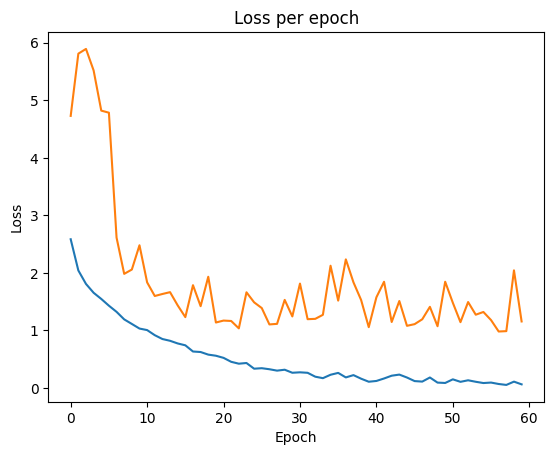

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

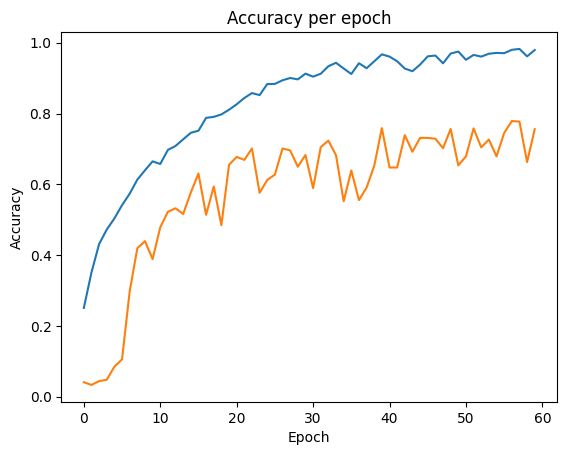

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()